<a href="https://colab.research.google.com/github/enki-zhou/Sundries_warehouse/blob/main/ee541_hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cuda
Epoch=0, loss=0.7452, accuracy=0.6892
val_Loss=0.5442, val_accuracy=0.8300
Epoch=1, loss=0.4255, accuracy=0.8654
val_Loss=0.4272, val_accuracy=0.8767
Epoch=2, loss=0.3374, accuracy=0.8967
val_Loss=0.3480, val_accuracy=0.8933
Epoch=3, loss=0.3034, accuracy=0.8958
val_Loss=0.3212, val_accuracy=0.8800
Epoch=4, loss=0.2759, accuracy=0.9121
val_Loss=0.3177, val_accuracy=0.8967
Epoch=5, loss=0.2507, accuracy=0.9096
val_Loss=0.2941, val_accuracy=0.9167
Epoch=6, loss=0.1254, accuracy=0.9513
val_Loss=0.0622, val_accuracy=0.9800
Epoch=7, loss=0.0526, accuracy=0.9838
val_Loss=0.1635, val_accuracy=0.9400
Epoch=8, loss=0.0600, accuracy=0.9788
val_Loss=0.0714, val_accuracy=0.9700
Epoch=9, loss=0.0349, accuracy=0.9892
val_Loss=0.1002, val_accuracy=0.9633


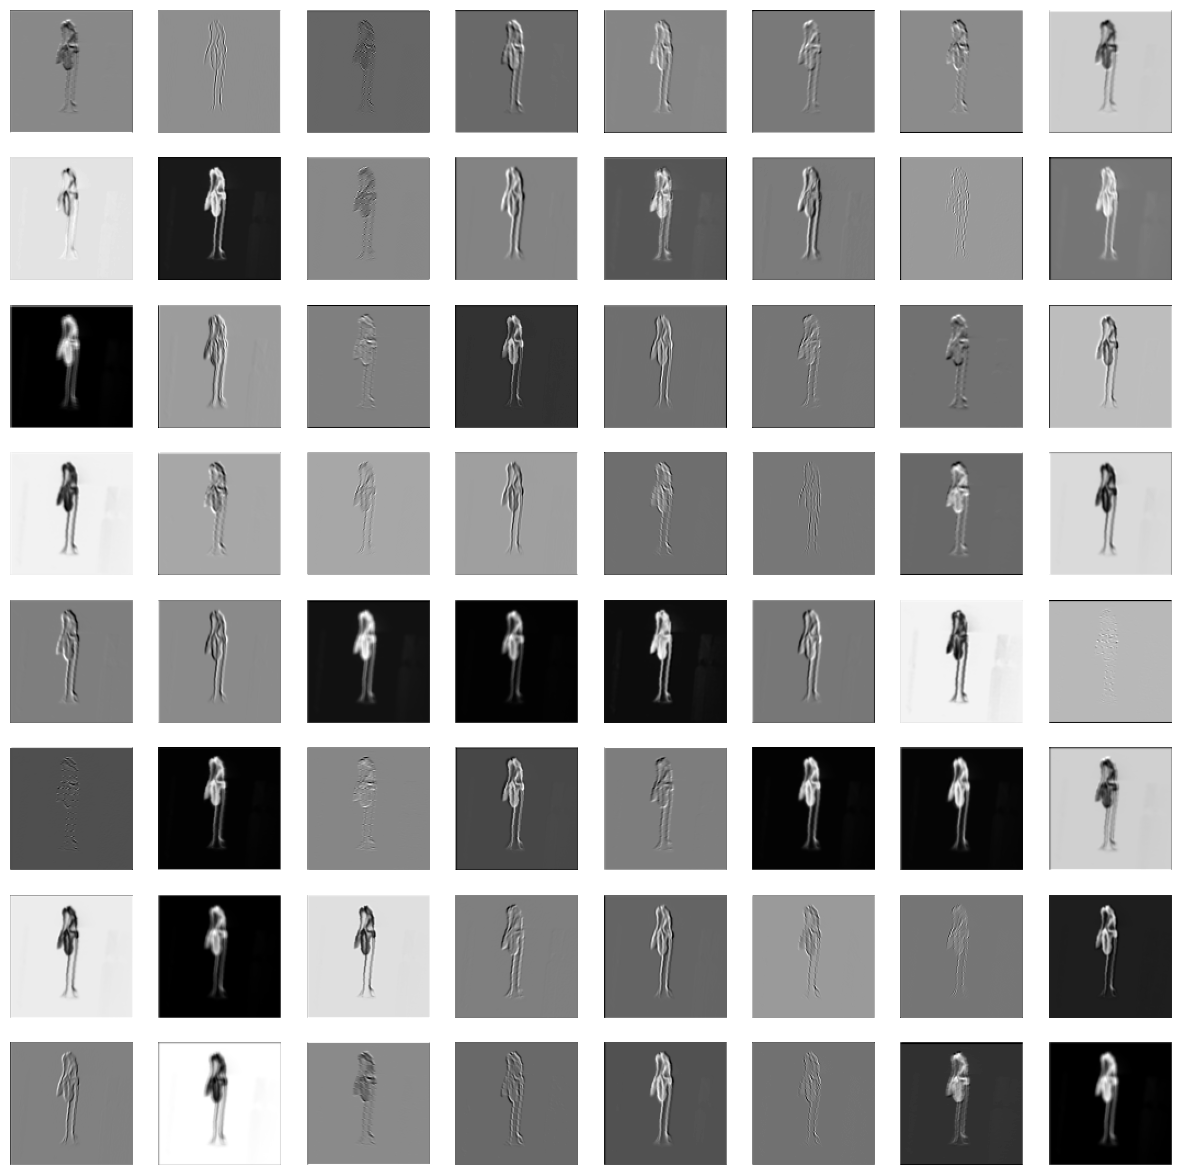

test_accuracy=0.9067


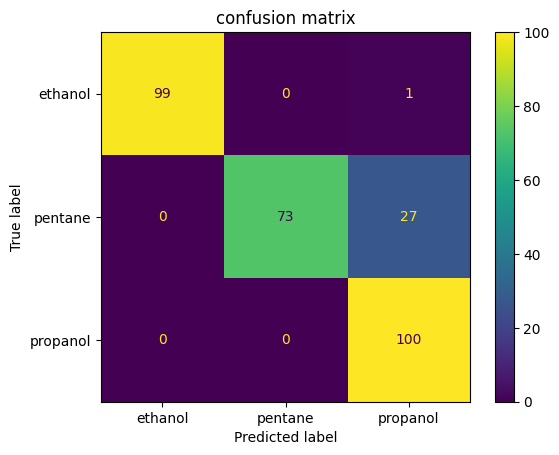

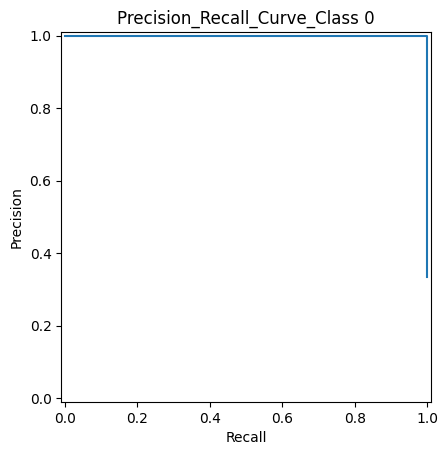

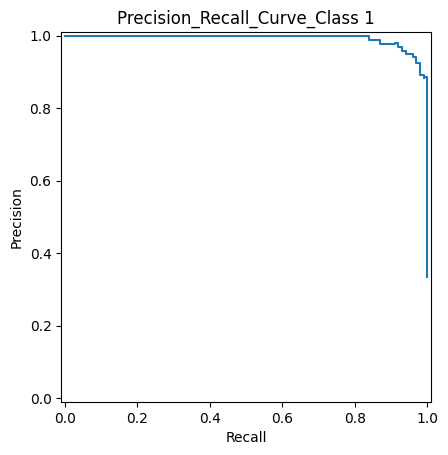

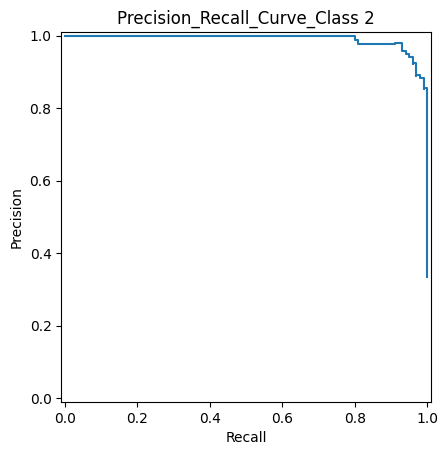

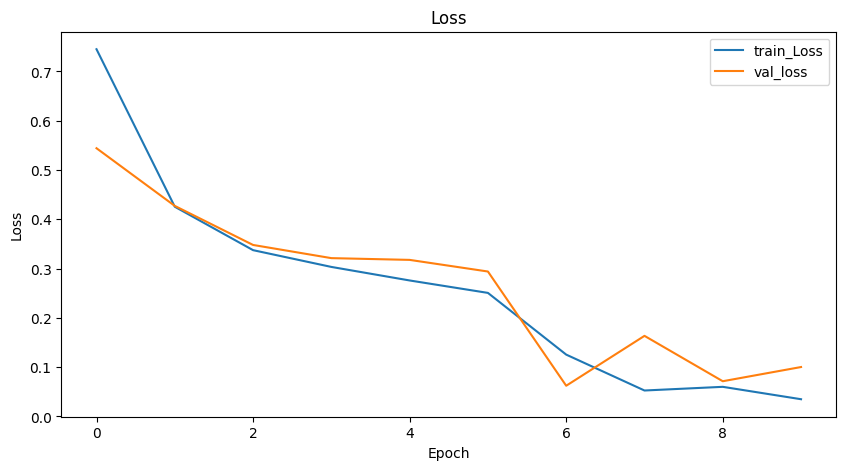

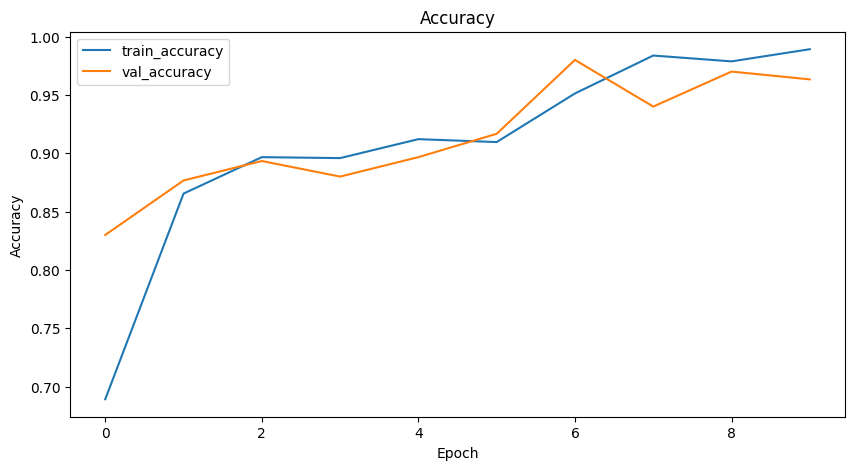

In [8]:
import torch
import torch.nn as nn
from torchvision.models import resnet34
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
import warnings
# import matplotlib
# matplotlib.use('TkAgg')
warnings.filterwarnings('ignore')


transform=transforms.Compose([transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ColorJitter(contrast=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset_path = "/content/drive/MyDrive/data"

dataset = ImageFolder(root=dataset_path, transform=transform)

train_dataset = ImageFolder(root="/content/drive/MyDrive/data/train", transform=transform)
val_dataset = ImageFolder(root="/content/drive/MyDrive/data/val", transform=transform)
test_dataset = ImageFolder(root="/content/drive/MyDrive/data/test", transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_class=3
model=resnet34(pretrained=True)
model.fc=nn.Linear(model.fc.in_features,num_class)

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.fc.parameters(), lr=1e-3)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

train_loss_list=[]
val_loss_list=[]
test_loss_list=[]
train_accuracy_list=[]
val_accuracy_list = []
epoch_list=[]
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    total = 0
    epoch_list.append(epoch)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = train_correct / total
    train_accuracy_list.append(train_acc)
    train_loss_list.append(train_loss / len(train_loader))
    print(f"Epoch={epoch}, loss={train_loss/len(train_loader):.4f}, accuracy={train_acc:.4f}")


    model.eval()
    val_loss = 0
    val_correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = val_correct / total
    val_accuracy_list.append(val_acc)
    val_loss_list.append(val_loss/len(val_loader))
    print(f"val_Loss={val_loss/len(val_loader):.4f}, val_accuracy={val_acc:.4f}")

    if epoch == 5:
        for param in model.layer4.parameters():
            param.requires_grad = True
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    elif epoch == 8:
        for param in model.parameters():
            param.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

def visualize_hook(module, input, output):
    plt.figure(figsize=(15, 15))
    for i in range(output.size(1)):
        plt.subplot(8, 8, i + 1)
        plt.imshow(output[0, i].detach().cpu().numpy(), cmap="gray")
        plt.axis("off")
    plt.savefig('7_conv1')
    plt.show()

layer_to_visualize = model.conv1
hook = layer_to_visualize.register_forward_hook(visualize_hook)

image, _ = test_dataset[0]
image = image.unsqueeze(0).to(device)
_ = model(image)
hook.remove()


model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    test_loss_epoch = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        test_loss = criterion(outputs, labels)
        test_loss_epoch += test_loss.item()
    test_loss_list.append(test_loss_epoch/len(test_loader))
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"test_accuracy={test_accuracy:.4f}")


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='viridis')
plt.title("confusion matrix")
plt.savefig('7_confusion_matrix')
plt.show()


all_labels_one_hot = torch.nn.functional.one_hot(torch.tensor(all_labels), num_classes=num_class).numpy()
for i in range(num_class):
    precision, recall, _ = precision_recall_curve(all_labels_one_hot[:, i], [prob[i] for prob in all_probs])
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title(f"Precision_Recall_Curve_Class {i}")
    plt.savefig(f'7_precision_recall_curve{i}')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch_list, train_loss_list, label='train_Loss')
plt.plot(epoch_list,val_loss_list,label='val_loss')
# plt.plot(epoch_list, test_loss_list, label='test_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.savefig('7_loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch_list, train_accuracy_list, label='train_accuracy')
plt.plot(epoch_list, val_accuracy_list, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.savefig('7_accuracy')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')